In [1]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
import datetime as dt

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
country = "KEN"

# API: all stations in country
all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName="+country

response = urlopen(all_stations_KEN_url)
data_json = json.loads(response.read())
stations = data_json["stationSearchResults"]

wigosIds = []

for station in data_json["stationSearchResults"]:
    # print(station["wigosId"])
    wigosId = str(station["wigosId"])
    wigosIds.append(wigosId)

print(wigosIds)

['0-404-300-301570787AS00074', '0-404-300-402261127AS63663', '0-404-300-271440721AS00049', '0-404-300-281480740AS00057', '0-404-300-160800395AS00001', '0-404-0-63707', '0-404-300-392191090AS63662', '0-404-0-63721', '0-404-300-040200100AS00113', '0-404-300-040200098AS00112', '0-404-300-301620807AS00073', '0-404-300-301580790AS00071', '0-404-300-402251125AS00038', '0-404-300-402281141AS00036', '0-404-300-402291146AS00033', '0-404-300-392181085AS63660', '0-404-300-361950974AS00015', '0-20000-0-63741', '0-404-300-472781389AS63747', '0-404-300-100470235AS00114', '0-404-300-372081037AS00024', '0-404-300-372000999AS00025', '0-404-300-372031019AS00022', '0-404-300-372101048AS00026', '0-20000-0-63688', '0-404-300-63686', '0-20000-0-63720', '0-404-0-63719', '0-404-300-341870932AS00005', '0-404-300-341840918A00001', '0-404-300-050210101AS00090', '0-404-0-63670', '0-20000-0-63723', '0-404-300-190950473AS00101', '0-404-300-060230111AS00047', '0-404-300-190950476AS00099', '0-404-300-070320150AS00107

In [38]:
# prepare data frame #
df_dates = pd.DataFrame(np.nan, index=[0],columns=["station", "dateEstablished", "firstDeploymentStart"])

for id in wigosIds:
    print(id)
    station = id

    observedProperties = []
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')

    with open(os.getcwd()+"/Files/File_"+id+".txt") as myFile:
        observedProperties_line = soup.find_all('observedProperty')
        observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
        observedProperties.append(observedProperties_notation)

    # Establishment date of station
    dateEstablished = soup.find_all('dateEstablished')
    if dateEstablished:
        dateEstablished = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateEstablished))[0]
    else: 
        dateEstablished = "unknown"


    # find earliest date of registered deployment start
    from functools import reduce
    #  list of unique observed properties 
    def unique(list1):
        ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
        return(ans)
    variables_u = unique(observedProperties[0])
    # print(variables_u)

    f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
    lines=f.readlines()
    all_dates = []


    positions = []
    for var in variables_u:
        variable = var
        station = id

        # find line numbers containing the WMDR notation of the observed property
        numbers = []

        with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
            for num, line in enumerate(myFile, 1):
                if variable in line:
                    numbers.append(num)

        # find the line numbers with <om:observedProperty
        obs = "observedProperty"
        numbers_obs = []

        for n in numbers:
            if obs in lines[n-1]:
                number = re.findall(r'\d+',lines[n-1])
                if number[0]==str(var):
                    numbers_obs.append(n)

        ### read 30 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
        
        for n in numbers_obs:
            start = "beginPosition"
            line_numbers = range(n-30,n)

            f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
            lines=f.readlines()
            
            for n in line_numbers:
                if start in lines[n]:
                    beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                    if beginning:
                        pd.to_datetime(beginning, format='%Y-%m-%d')
                        positions.append(beginning[0])
                    else:
                        positions.append(np.nan)
        
    print("positions: ", positions)

    # find first date
    pos = pd.to_datetime(positions, format='%Y-%m-%d')
    print(pos)
    firstDeploymentStart = np.min(pos) 
    # print(firstDeploymentStart)
    

    new_row = {"station":station,"dateEstablished":dateEstablished,"firstDeploymentStart":firstDeploymentStart}
    df_dates.loc[len(df_dates)] = new_row 

df_dates.drop([0], axis=0, inplace=True)
df_dates


0-404-300-301570787AS00074
positions:  ['2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29']
DatetimeIndex(['2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29',
               '2021-11-29', '2021-11-29'],
              dtype='datetime64[ns]', freq=None)
2021-11-29 00:00:00
0-404-300-402261127AS63663
positions:  ['2020-12-15', '2020-09-22', '2023-05-16', '2020-12-15', '2020-12-15', '2020-09-22', '2020-09-22', '2020-12-15', '2020-12-15']
DatetimeIndex(['2020-12-15', '2020-09-22', '2023-05-16', '2020-12-15',
               '2020-12-15', '2020-09-22', '2020-09-22', '2020-12-15',
               '2020-12-15'],
              dtype='datetime64[ns]', freq=None)
2020-09-22 00:00:00
0-404-300-271440721AS00049
positions:  ['2021-11-18', '2021-11-18', '2021-11-18', '2021-11-18', '2021-11-18', '2021-11-18']
DatetimeIndex(['2021-11-18', '2021-11-18', '2021-11-18', '2021-11-18',
               '2021-11-18', '2021-11-18'],
              dtype='datetime64[ns]', freq=Non

,station,dateEstablished,firstDeploymentStart,variable
1,0-404-300-301570787AS00074,2021-11-29,2021-11-29,NaN
2,0-404-300-402261127AS63663,2020-09-22,2020-09-22,NaN
3,0-404-300-271440721AS00049,2021-11-18,2021-11-18,NaN
4,0-404-300-281480740AS00057,2021-11-29,2021-11-29,NaN
5,0-404-300-160800395AS00001,2022-09-25,2022-09-25,NaN
...,...,...,...,...
156,0-22000-0-1901045,2009-06-23,2009-06-23,NaN
157,0-22000-0-1901046,2009-06-23,2009-06-23,NaN
158,0-22000-0-1901047,2009-06-25,2009-06-25,NaN
159,0-22000-0-1901048,2009-06-24,2009-06-24,NaN


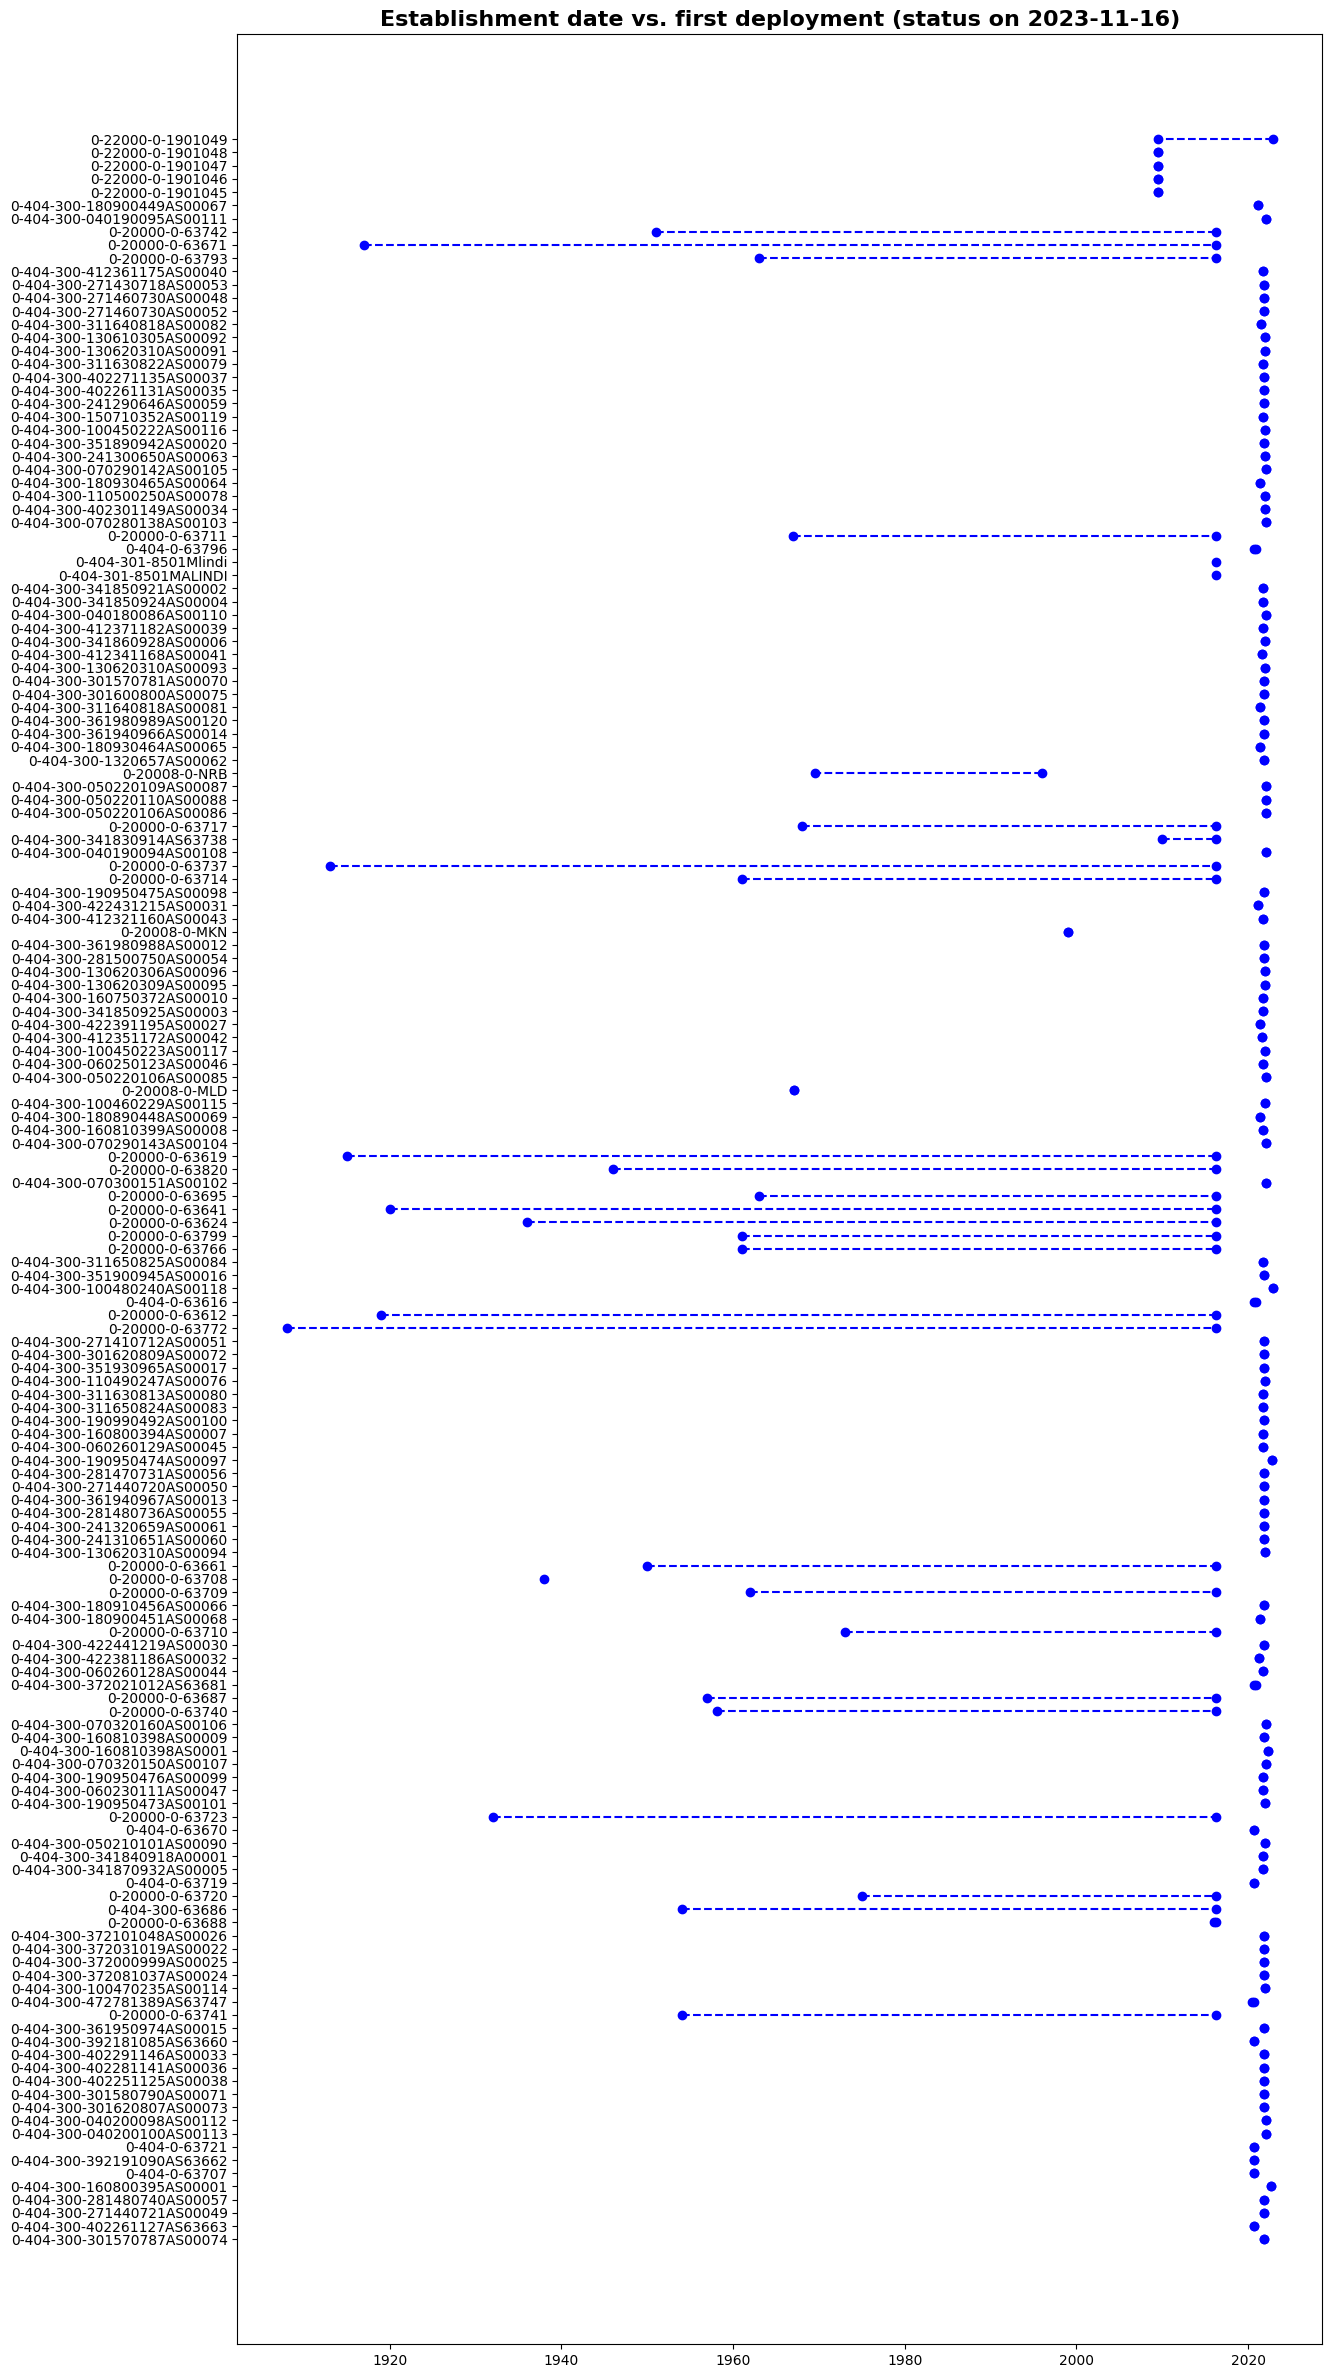

In [51]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,30))

# variables = variables_u

for id in range(0,len(wigosIds)):
    df_var = df_dates[df_dates["station"]==str(wigosIds[id])]

    x_values = [pd.to_datetime(df_var["dateEstablished"]), pd.to_datetime(df_var["firstDeploymentStart"])]
    # print(x_values)
    plt.plot(x_values, [id,id], 'bo', linestyle="--")

# print(variables)
names = []
for var in range(0,len(wigosIds)):
    variable_df = df_dates[df_dates["station"]==str(wigosIds[var])]
    # print(variable_df["station"])
    name = str(variable_df.iloc[0]["station"])
    # print(name)
    names.append(name)
    # print(names)
# print(names)
# print(len(names))
n = range(0,len(names))
# print(len(n))
plt.yticks(n,names)

# title
# plt.title(r'$\bf{"Establishment" + "date" + "vs" + "first" + "deployment"}$' + ' (status on ' + pd.Timestamp.today().strftime("%Y-%m-%d") + ')', fontsize=16)
plt.title("Establishment date vs. first deployment"+ ' (status on ' + pd.Timestamp.today().strftime("%Y-%m-%d") + ')', fontsize=16, fontweight="bold")


# save figure
fig.savefig(os.getcwd()+"/Plots/EstablshmentDate_vs_FirstDeployment.jpeg", bbox_inches='tight')